In [1]:
#
#  Creating a pyomo parest version of example from James Rawlings Reactor Design Book
#  https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [3]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae
import scipy.stats as spstat
from pyomo.contrib.interior_point.inverse_reduced_hessian import inv_reduced_hessian_barrier

In [4]:
data_df = pd.read_csv('hbv_data.csv')
data_df.head()

,t,ca_exp,cb_exp,cc_exp
0,0.0,0.734562,0.000000,0.000000
1,2.0,0.707371,3.444986,373.654198
2,4.0,0.521003,6.148200,280.451066
3,6.0,0.680192,7.458215,301.503717
4,8.0,0.716159,8.115554,363.551492


In [5]:
data = [{'ca_exp': {k: v for (k, v) in zip(data_df.t, data_df.ca_exp)},
         'cb_exp': {k: v for (k, v) in zip(data_df.t, data_df.cb_exp)},
         'cc_exp': {k: v for (k, v) in zip(data_df.t, data_df.cc_exp)}
        }]

In [6]:
def hbv_model(data):
    
    ca_exp = data['ca_exp']
    cb_exp = data['cb_exp']
    cc_exp = data['cc_exp']
    texp = list(ca_exp.keys())
    
    ca0 = 1.0
    cb0 = 0.0
    cc0 = 0.0
    
    m = pyo.ConcreteModel()
    
    m.k1 = pyo.Var(initialize = 6.3, bounds = (1e-3, 10))
    m.k2 = pyo.Var(initialize = 0.07, bounds = (1e-3, 10))
    m.k3 = pyo.Var(initialize = 1412, bounds = (100, 5000))
    m.k4 = pyo.Var(initialize = 0.17, bounds = (1e-3, 10))
    m.k5 = pyo.Var(initialize = 0.69, bounds = (1e-3, 10))
    m.k6 = pyo.Var(initialize = 3.5e-6, bounds = (1e-6, 1e-5))
    
    m.time = dae.ContinuousSet(bounds = (0, max(texp)), initialize = texp)
    
    m.ca = pyo.Var(m.time, initialize = ca0)
    m.cb = pyo.Var(m.time, initialize = cb0)
    m.cc = pyo.Var(m.time, initialize = cc0)
    
    m.dca = dae.DerivativeVar(m.ca)
    m.dcb = dae.DerivativeVar(m.cb)
    m.dcc = dae.DerivativeVar(m.cc)
    
    def _dca_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dca[t] == m.k2 * m.cb[t] - m.k4 * m.ca[t]
    m.dca_eq = pyo.Constraint(m.time, rule = _dca_eq)

    def _dcb_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcb[t] == m.k1 * m.ca[t] - m.k2 * m.cb[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcb_eq = pyo.Constraint(m.time, rule = _dcb_eq)
    
    def _dcc_eq(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return m.dcc[t] == m.k3 * m.ca[t] - m.k5 * m.cc[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcc_eq = pyo.Constraint(m.time, rule = _dcc_eq)

    def _initcon(m):
        yield m.ca[m.time.first()] == ca0
        yield m.cb[m.time.first()] == cb0
        yield m.cc[m.time.first()] == cc0
    m.initcon = pyo.ConstraintList(rule = _initcon)
        
    def wssq_rule(m):
        return sum((m.ca[t] - ca_exp[t]) ** 2 + 
                   1e-2 * (m.cb[t] - cb_exp[t]) ** 2 + 
                   1e-4 * (m.cc[t] - cc_exp[t]) ** 2 
                   for t in texp) 
    m.wssq = pyo.Objective(rule=wssq_rule)
   
    disc = pyo.TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=60, ncp=4)
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m 

In [7]:
# Estimate parameters
mest = hbv_model(data[0])
solver = pyo.SolverFactory('ipopt')
solver.solve(mest, tee = True)

Ipopt 3.14.5: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     8883
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2073

Total number of variables............................:     1449
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1443
Total number of inequ

  81  1.3642920e+04 9.86e+01 5.35e+08  -1.0 4.09e+02    -  2.72e-01 1.00e+00f  1
  82  1.3413385e+04 2.19e+00 3.72e+08  -1.0 1.41e+02    -  4.56e-03 1.00e+00f  1
  83  1.3132225e+04 6.65e+01 1.90e+07  -1.0 1.86e+02    -  6.28e-01 1.00e+00f  1
  84  1.3174920e+04 1.85e+00 2.38e+05  -1.0 8.46e+01    -  1.00e+00 1.00e+00h  1
  85  1.3158417e+04 7.74e-01 1.79e+05  -1.0 2.91e+01    -  1.00e+00 1.00e+00f  1
  86  1.3157558e+04 2.32e-03 2.18e+02  -1.0 1.37e+00    -  1.00e+00 1.00e+00h  1
  87  1.3157560e+04 9.99e-09 1.55e-03  -1.0 3.10e-03    -  1.00e+00 1.00e+00h  1
  88  1.3157559e+04 3.45e-05 2.17e+01  -3.8 1.63e-01    -  1.00e+00 1.00e+00h  1
  89  1.3157559e+04 3.57e-11 2.93e-07  -3.8 3.12e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.3157559e+04 7.66e-11 4.93e-05  -5.7 2.43e-04    -  1.00e+00 1.00e+00h  1
  91  1.3157559e+04 5.66e-11 1.35e-07  -5.7 7.10e-11    -  1.00e+00 1.00e+00h  1
  92  1.3157559e+04 3.91e-11

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1443, 'Number of variables': 1449, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.5\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.8685603141784668}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [8]:
# Parameter Estimates
parest = {'k1': mest.k1(), 'k2': mest.k2(), 'k3': mest.k3(), 'k4': mest.k4(), 'k5': mest.k5(), 'k6': mest.k6()}
parest

{'k1': 2.0499437714318423,
 'k2': 0.01940662424557941,
 'k3': 192.93788256781954,
 'k4': 0.19027088517622365,
 'k5': 0.3690144565753473,
 'k6': 8.23444344328863e-06}

In [13]:
solve_result, inv_red_hes = inv_reduced_hessian_barrier(mest, 
                    independent_variables= [mest.k1, mest.k2, mest.k3, mest.k4, mest.k5, mest.k6],
                    tee=True)

Ipopt 3.14.5: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     8883
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2073

MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 128830 to 257660 and la from 199390 to 399558 and factorize again.
Total number of variables............................:     1449
                     variables with only lower bounds:        0
                variables with

In [27]:
# Parameter Estimates
parest = {'k1': mest.k1(), 'k2': mest.k2(), 'k3': mest.k3(), 'k4': mest.k4(), 'k5': mest.k5(), 'k6': mest.k6()}
parest

{'k1': 2.0499437714310216,
 'k2': 0.01940662424564039,
 'k3': 192.93788256846437,
 'k4': 0.1902708851768589,
 'k5': 0.36901445657662724,
 'k6': 8.234443443279917e-06}

In [14]:
inv_red_hes

array([[ 9.73350732e-05, -4.58281220e-06, -6.00485747e-03,
        -4.22594351e-05, -1.56907071e-05,  5.03843672e-10],
       [-4.58281220e-06,  3.30374554e-07,  4.94160300e-04,
         3.38652064e-06,  9.74775746e-07, -4.12579520e-11],
       [-6.00485747e-03,  4.94160301e-04,  8.36728342e+00,
         5.39016493e-03,  1.60019385e-02, -8.40170633e-08],
       [-4.22594351e-05,  3.38652064e-06,  5.39016493e-03,
         3.54427743e-05,  9.91588204e-06, -4.36568166e-10],
       [-1.56907071e-05,  9.74775747e-07,  1.60019385e-02,
         9.91588205e-06,  3.19652219e-05, -1.47676633e-10],
       [ 5.03843672e-10, -4.12579520e-11, -8.40170632e-08,
        -4.36568166e-10, -1.47676633e-10,  5.56675728e-15]])

In [15]:
n = len(data[0]['ca_exp']) + len(data[0]['cb_exp']) + len(data[0]['cc_exp'])
p = 6
s2 = mest.wssq() / (n - p)
print('n:', n, ' p:', p, ' s2:', s2)
# Covariance Matrix
cov = 2 * s2 * inv_red_hes
cov

n: 153  p: 6  s2: 89.50720723269268


array([[ 1.74243811e-02, -8.20389443e-04, -1.07495604e+00,
        -7.56504803e-03, -2.80886274e-03,  9.01952799e-08],
       [-8.20389442e-04,  5.91418074e-05,  8.84618168e-02,
         6.06236010e-04,  1.74498909e-04, -7.38576812e-09],
       [-1.07495604e+00,  8.84618169e-02,  1.49786434e+03,
         9.64917218e-01,  2.86457764e+00, -1.50402654e-05],
       [-7.56504803e-03,  6.06236010e-04,  9.64917218e-01,
         6.34476748e-03,  1.77508582e-03, -7.81519946e-08],
       [-2.80886274e-03,  1.74498910e-04,  2.86457764e+00,
         1.77508582e-03,  5.72223549e-03, -2.64362460e-08],
       [ 9.01952799e-08, -7.38576812e-09, -1.50402654e-05,
        -7.81519946e-08, -2.64362460e-08,  9.96529795e-13]])

In [18]:
parm_sd = np.sqrt(np.diag(cov))
conf_mult = np.sqrt(p * spstat.f.ppf(0.95, p, n - p))
print('parameter estimate')
print(parest)
print("conf multiplier:", conf_mult)
conf_int = conf_mult * parm_sd
print("confidence interval delta from nominal [k1, k2, k3, k4, k5, k6]")
print(conf_int)

parameter estimate
{'k1': 2.0499437714318423, 'k2': 0.01940662424557941, 'k3': 192.93788256781954, 'k4': 0.19027088517622365, 'k5': 0.3690144565753473, 'k6': 8.23444344328863e-06}
conf multiplier: 3.600647920002456
confidence interval delta from nominal [k1, k2, k3, k4, k5, k6]
[4.75290724e-01 2.76903186e-02 1.39353185e+02 2.86806185e-01
 2.72372665e-01 3.59439500e-06]


In [26]:
print("confidence interval % delta from nominal [k1, k2, k3, k4, k5, k6]")
conf_int_pct = []
for (i, v) in enumerate(parest.items()):
    conf_int_pct.append(conf_int[i] / v[1] * 100.0)
print([np.round(x) for x in conf_int_pct])

confidence interval % delta from nominal [k1, k2, k3, k4, k5, k6]
[23.0, 143.0, 72.0, 151.0, 74.0, 44.0]


In [9]:
ms = hbv_model(data[0])
ms.k1.fix(mest.k1())
ms.k2.fix(mest.k2())
ms.k3.fix(mest.k3())
ms.k4.fix(mest.k4())
ms.k5.fix(mest.k5())
ms.k6.fix(mest.k6())

solver = pyo.SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.14.5: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6963
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      393

Total number of variables............................:     1443
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1443
Total number of inequ

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1443, 'Number of variables': 1443, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.5\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.0461122989654541}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

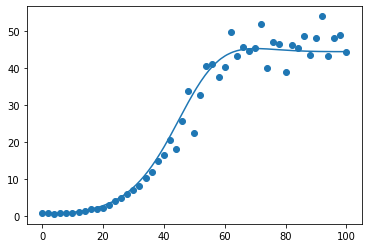

In [10]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.scatter(data[0]['ca_exp'].keys(), data[0]['ca_exp'].values())

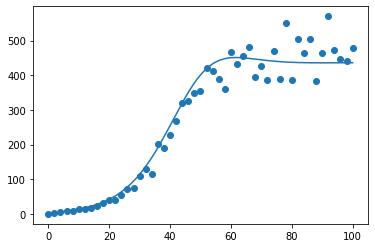

In [11]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cb[t]() for t in ms.time])
ax.scatter(data[0]['cb_exp'].keys(), data[0]['cb_exp'].values())

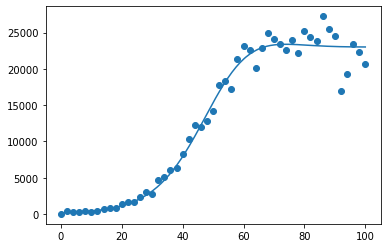

In [12]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cc[t]() for t in ms.time])
ax.scatter(data[0]['cc_exp'].keys(), data[0]['cc_exp'].values())